<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# RNN Text Classifier

by Fabian Märki

## Summary
The aim of this notebook is to build a RNN text classifier. It utilize pretrained word embeddings in order to take advantage of [transfer learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning) in NLP. Additionally, it sets the stage for hyperparameter tuning and model design optimization.

## Links
- [Enabling GPU on Google Colab](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm)
- Tutorial on [Text Classification](https://www.tensorflow.org/tutorials/load_data/text) with TensorFlow
- [KerasNLP](https://keras.io/keras_nlp/) as a (short path) alternative 

This notebook contains assigments: <font color='red'>Questions are written in red.</font>

<a href="https://colab.research.google.com/github/markif/2024_HS_DAS_NLP_Notebooks/blob/master/06_a_RNN_Text_Classifier.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.9.8,<0.10.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.colab import runs_on_colab

# should prevent verbose logging
set_log_level(2)

import pandas as pd
import numpy as np
import tensorflow as tf

2024-08-24 13:16:58.456161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 13:16:58.472170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 13:16:58.476808: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 6.5.0-44-generic
Python version: 3.11.0rc1
CPU cores: 6
RAM: 31.1GB total and 16.2GB available
Tensorflow version: 2.17.0
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


/usr/local/lib/python3.11/dist-packages/pynvml/smi.py:5: FutureWarning: The pynvml.smi module is deprecated and will be removed in the next release of pynvml. Please use pynvml_utils:
(e.g. `from pynvml_utils import nvidia_smi`)
  warnings.warn(


Download the [cleaned](https://github.com/markif/2024_FS_CAS_NLP_LAB_Notebooks/blob/master/02_a_Text_Cleaning.ipynb) and [preprocessed](https://github.com/markif/2024_FS_CAS_NLP_LAB_Notebooks/blob/master/02_b_Text_Normalization.ipynb) doctor reviews dataset. 

In [3]:
%%time
download("https://drive.switch.ch/index.php/s/0hE8wO4FbfGIJld/download", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

CPU times: user 7.88 s, sys: 1.68 s, total: 9.56 s
Wall time: 5.59 s


Exclude *neutral* ratings so that the task becomes a binary classification.

In [4]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [5]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


Import some helper functions...

In [6]:
from fhnw.nlp.utils.ploting import plot_history
from fhnw.nlp.utils.ploting import report_classification_results

from fhnw.nlp.utils.params import build_model_cnn
from fhnw.nlp.utils.params import build_model_rnn
from fhnw.nlp.utils.params import build_preprocessed_dataset
from fhnw.nlp.utils.params import compile_model
from fhnw.nlp.utils.params import create_label_binarizer_and_set
from fhnw.nlp.utils.params import create_text_preprocessor
from fhnw.nlp.utils.params import dataframe_to_dataset
from fhnw.nlp.utils.params import extract_embedding_layer_and_set
from fhnw.nlp.utils.params import extract_text_vectorization_and_set
from fhnw.nlp.utils.params import extract_vocabulary_and_set
from fhnw.nlp.utils.params import get_train_test_split
from fhnw.nlp.utils.params import predict_classification
from fhnw.nlp.utils.params import re_compile_model
from fhnw.nlp.utils.params import save_model
from fhnw.nlp.utils.params import train_model

Setup the *params* dictionary which is used to specify hyperparameters and model design choices (and is also used to store intermediate results).  This sets the stage for a possible hyperparameter tuning and model design optimization (not part of this notebook).

<font color='red'>**TASK: You might want to try different *word embeddings* by changing the `embedding_type` parameter (values: *fasttext*, *bytepair*, *word2vec*).**</font>

In [7]:
params = {
    "verbose": True,
    "shuffle": True,
    # modify batch_size in case you experience memory issues
    "batch_size": 128,
    "X_column_name": "text_clean",
    "y_column_name": "label",
    # modify to try different word embeddings
    "embedding_type": "fasttext",
    "embedding_dim": 300,
    "embedding_trainable": False,
    "embedding_fasttext_model": "cc.de.300.bin",
    "embedding_word2vec_model_url": "https://cloud.devmount.de/d2bc5672c523b086/german.model",
    "embedding_spacy_model": "de_core_news_md",
    "embedding_tensorflow_hub_url": "https://tfhub.dev/google/nnlm-de-dim128-with-normalization/2",
    "model_type": "rnn",
}

if runs_on_colab() and params["embedding_type"] == "fasttext":
    # colab as problems handling such large files
    model_name = "cc.de.50.bin"
    download("https://drive.switch.ch/index.php/s/fncH84BgISMlT3v/download", model_name)
    params["embedding_dim"] = 50
    params["embedding_fasttext_model"] = model_name
    

...extract the vocabulary...

In [8]:
create_label_binarizer_and_set(params, data)
extract_vocabulary_and_set(params, data)

Inferred classification type: binary
Median sequence length: 46
Percentil (0.98) cutoff sequence length: 230
Max sequence length: 408
Used embedding sequence length: 230


...build the TextVectorization layer...

In [9]:
extract_text_vectorization_and_set(params)

Vocabulary length: 189790


...import and load word embeddings...

In [10]:
%%time

extract_embedding_layer_and_set(params)

/usr/local/lib/python3.11/dist-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


Embedding type: fasttext
Number of null word embeddings: 9
Words not found in total: 9
Words without embedding (9/9): ['úm', 'ìn', 'üw', 'jé', 'öz', 'èn', 'äk', '', 'öä']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


CPU times: user 5.8 s, sys: 5.57 s, total: 11.4 s
Wall time: 12.6 s


...prepare the training/test/validation data...

In [11]:
data_train, data_test = get_train_test_split(params, data)
data_train, data_val = get_train_test_split(params, data_train)

dataset_train = dataframe_to_dataset(params, data_train)
dataset_test = dataframe_to_dataset(params, data_test)
dataset_val = dataframe_to_dataset(params, data_val)

264949 train examples
66238 test examples
211959 train examples
52990 test examples


In [12]:
for text, labels in dataset_train.take(1):
    print(text)
    print(labels)

tf.Tensor(b'tolle \xc3\xa4rztin , h\xc3\xb6rt auch mal zu auch wenn es l\xc3\xa4nger dauert . sind umgezogen und halten ihr troztdem die treue ! ! wurde nie entt\xc3\xa4uscht', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


Next we will build our data pipeline. 

In [13]:
dataset_train_preprocessed = build_preprocessed_dataset(params, dataset_train, False)
dataset_val_preprocessed = build_preprocessed_dataset(params, dataset_val, False)

<font color='red'>**TASK: Improve the RNN model defined in `build_model_rnn` (play with rnn_units, activation function, rnn type ([RNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/), [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/), [GRU](https://keras.io/api/layers/recurrent_layers/gru/)), model design ([Bidirectional](https://keras.io/api/layers/recurrent_layers/bidirectional/), [Multi-Layer RNN](https://wandb.ai/lavanyashukla/visualize-models/reports/How-to-stack-multiple-LSTMs-in-keras---VmlldzoxOTg2MTY) ) etc...)**</font>

You might get inspiration from:
- [Working with RNNs](https://keras.io/guides/working_with_rnns/)
- [Develop a Bidirectional LSTM For Sequence Classification](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/)

In [14]:
def build_model_rnn(params):
    """Builds a rnn classifier (only partially) based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    from tensorflow import keras
    
    # choose the output activation function based on the classification type
    classification_type = params.get("classification_type", "binary")
    if classification_type == "binary":
        output_activation = "sigmoid"
    elif classification_type == "multi-class":
        output_activation = "softmax"
    elif classification_type == "multi-label":
        output_activation = "sigmoid"
    else:
        raise TypeError("Unknown classification_type "+classification_type)
    
    X_column_name = params.get("X_column_name", "text_clean")
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"]
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1
    
    
    model = keras.Sequential(name="rnn")
    # A text input layer
    model.add(keras.layers.InputLayer(shape=(1,), dtype=tf.string, name=X_column_name))
    # The first layer in our model is the vectorization layer. After this layer,
    # we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model.add(vectorize_layer)
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'. 
    model.add(embedding_layer)
    
    # build the RNN
    rnn_units = 32
    model.add(keras.layers.Bidirectional(
        # dropout (regularization) could make sense here
        keras.layers.LSTM(
            rnn_units, 
            return_sequences=True # needed since we do a GlobalMaxPool1D
        )
    ))
    # add global max pooling
    model.add(keras.layers.GlobalMaxPool1D(name="global_max_pool"))
    # an alternative
    # model.add(keras.layers.GlobalAveragePooling1D(name="global_average_pool"))
    # another alternative (but ensure fixed time dimension by setting TextVectorization.output_sequence_length and Embedding.input_length)
    # model.add(keras.layers.Flatten(name="flatten"))
    # model.add(keras.layers.Dense(100, activation="relu", name="dense"))
    
    # do not forget Dropout (regularization) for a more sophisticated model
    
    # add the classification head
    model.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))
    
    return model

**Note: The run you see below is from a build_model_rnn(...) model (i.e. your output might look different)!**

In [15]:
model = build_model_rnn(params)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pool' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "rnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 300)      │    56,937,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 64)       │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pool                 │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,022,313 (217.52 MB)

 Trainable params: 85,313 (333.25 KB)

 Non-trainable params: 56,937,000 (217.20 MB)

In [16]:
compile_model(params, model)

In [17]:
params["training_epochs"] = 10
history = train_model(params, model, dataset_train_preprocessed, dataset_val_preprocessed)

Epoch 1/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9455 - loss: 0.1389 - val_accuracy: 0.9789 - val_loss: 0.0567
Epoch 2/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9802 - loss: 0.0549 - val_accuracy: 0.9813 - val_loss: 0.0525
Epoch 3/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9834 - loss: 0.0459 - val_accuracy: 0.9813 - val_loss: 0.0524
Epoch 4/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9860 - loss: 0.0400 - val_accuracy: 0.9816 - val_loss: 0.0544
Epoch 5/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9881 - loss: 0.0347 - val_accuracy: 0.9811 - val_loss: 0.0555
Epoch 6/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9901 - loss: 0.0297 - val_accuracy: 0.9807 - val_loss: 0.0605
Epoch 7/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9912 - loss: 0.0263 - val_accuracy: 0.9807 - val_loss: 0.0652
Epoch 8/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.9927 -

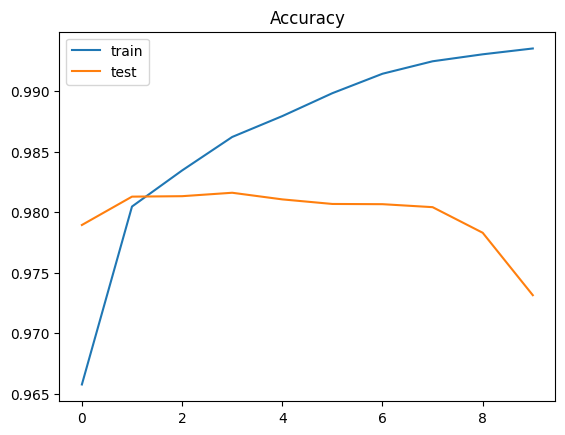

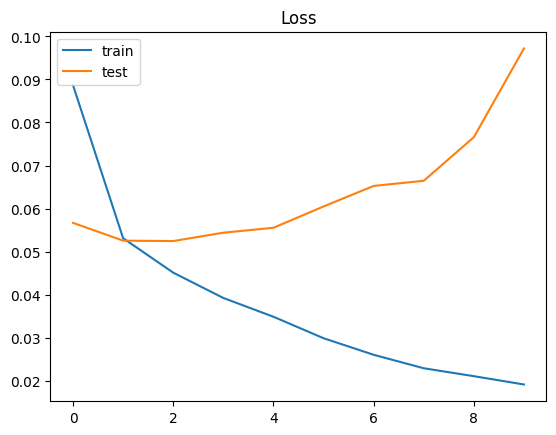

In [18]:
plot_history(history)

Quite overfitted. Training could stop after ~3 epochs and some regularizations (like dropout) could also make sense.  

Unfreezing the entire model (i.e. make the embedding layer trainable) and re-train the model could bring further improvements (similar to what is done in the [Transfer Learning](https://www.tensorflow.org/guide/keras/transfer_learning) tutorial). 

Check performance on all data.

In [19]:
from fhnw.nlp.utils.params import predict_classification
from fhnw.nlp.utils.ploting import report_classification_results

In [20]:
y, y_pred, y_pred_prob = predict_classification(params, data, model)

  13/2588 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step  

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pool' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


2588/2588 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step


Set Population: 331187
Accuracy: 0.9816


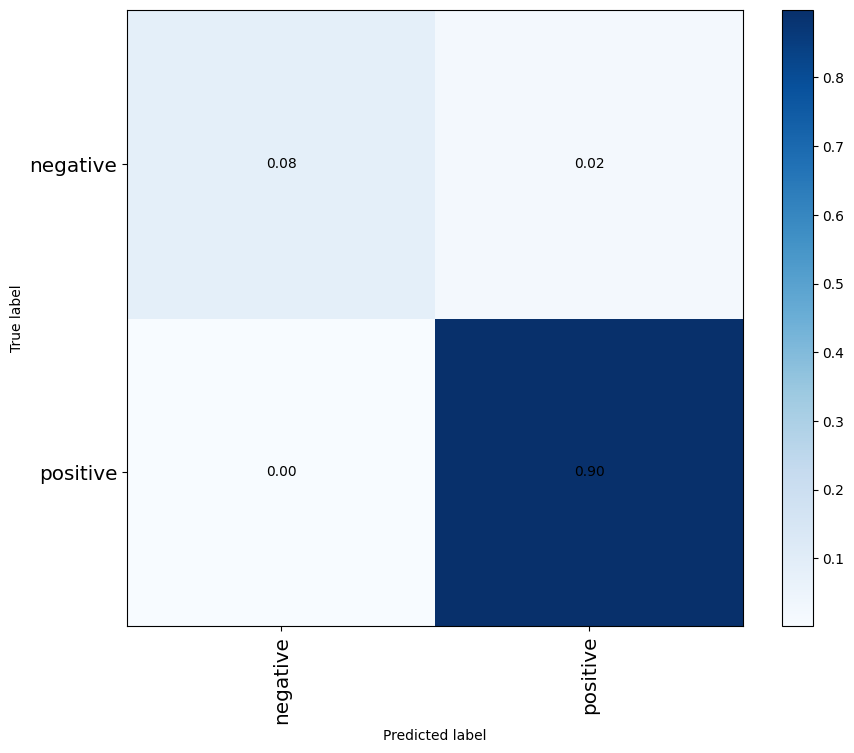

              precision    recall  f1-score   support

    negative       0.98      0.83      0.90     33022
    positive       0.98      1.00      0.99    298165

    accuracy                           0.98    331187
   macro avg       0.98      0.92      0.95    331187
weighted avg       0.98      0.98      0.98    331187

CPU times: user 4.67 s, sys: 156 ms, total: 4.83 s
Wall time: 4.62 s


In [21]:
%%time

report_classification_results(params, data[params.get("y_column_name", "label")].tolist(), y_pred)

Check performance on test data.

In [22]:
y_test, y_test_pred, y_test_pred_prob = predict_classification(params, data_test, model)

518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


Set Population: 66238
Accuracy: 0.9743


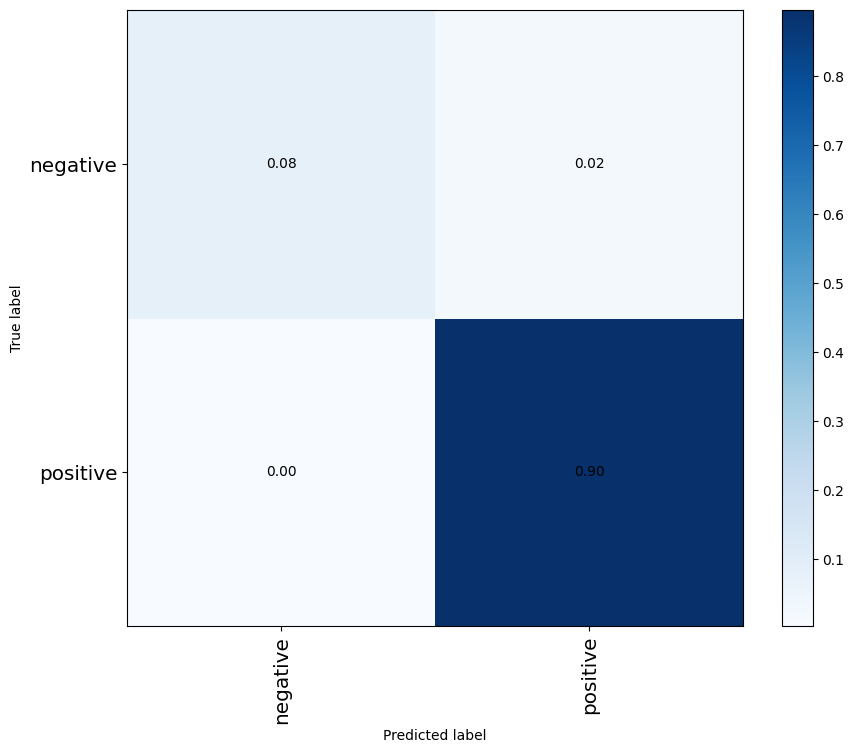

              precision    recall  f1-score   support

    negative       0.95      0.78      0.86      6604
    positive       0.98      1.00      0.99     59634

    accuracy                           0.97     66238
   macro avg       0.96      0.89      0.92     66238
weighted avg       0.97      0.97      0.97     66238

CPU times: user 1.04 s, sys: 184 ms, total: 1.23 s
Wall time: 1.02 s


In [23]:
%%time

report_classification_results(params, data_test[params.get("y_column_name", "label")].tolist(), y_test_pred)